In [1]:
%matplotlib notebook
# Switch to inline if debugging plotting.
# %matplotlib inline

import os
import pickle
import sys

from matplotlib import animation
import matplotlib.pyplot as plt
import numpy as np

### Load evaluation results.

In [2]:
# Replace with the directory containing evaluation outputs.
stats_dir = "../scripts/eval_scripts/logs/planner_eval/run-1rdonjl7_0/"
scene_type = "safer_slow"
risk_level = 1.0
num_samples = 256

filepath = os.path.join(stats_dir, f"{scene_type}_{num_samples}_samples_risk_level_{risk_level}_in_predictor.pkl")
with open(filepath, "rb") as infile:
    predictor_data = pickle.load(infile)
filepath = os.path.join(stats_dir, f"{scene_type}_{num_samples}_samples_risk_level_{risk_level}_in_planner.pkl")
with open(filepath, "rb") as infile:
    planner_data = pickle.load(infile)

### Find the most relevant episodes.

In [3]:
def print_riskiest_episodes(data, max_ep_id=10000, num_to_print=10, key="interaction_risk"):
    episode_id_risk = []
    for episode_id in range(max_ep_id):
        if episode_id not in data:
            break
        episode_id_risk.append((episode_id, data[episode_id][key]))
    episode_id_risk = sorted(episode_id_risk, key=lambda x: x[1], reverse=True)
    
    print("Riskiest episodes:")
    for ep_id, risk in episode_id_risk[:num_to_print]:
        print(f"episode id: {ep_id}\trisk: {risk:0.4f}")

def print_largest_risk_difference_episodes(
        data_a, 
        data_b, 
        max_ep_id=10000, 
        key="interaction_risk", 
        num_to_print=10):
    """Plots the episodes where the risk of a is most larger than that of b."""
    risk_a = []
    risk_b = []
    for episode_id in range(max_ep_id):
        if episode_id not in data_a or episode_id not in data_b:
            break
        risk_a.append(data_a[episode_id][key])
        risk_b.append(data_b[episode_id][key])
    risk_a = np.array(risk_a)
    risk_b = np.array(risk_b)
    
    diff = risk_a - risk_b
    indices = np.argsort(diff)[::-1]
    
    print("Episdoes where the first data is risker than the second")
    for episode_id in indices[:num_to_print]:
        print(f"episode_id: {episode_id}\tfirst data risk: {risk_a[episode_id]:0.4f}\tsecond data risk: {risk_b[episode_id]:0.4f}")

In [4]:
print_riskiest_episodes(predictor_data)

Riskiest episodes:
episode id: 66	risk: 1.1713
episode id: 48	risk: 1.0506
episode id: 32	risk: 1.0245
episode id: 37	risk: 1.0139
episode id: 39	risk: 0.9978
episode id: 84	risk: 0.9266
episode id: 24	risk: 0.9190
episode id: 79	risk: 0.8993
episode id: 75	risk: 0.8989
episode id: 71	risk: 0.8468


In [6]:
print_largest_risk_difference_episodes(predictor_data, planner_data)

Episdoes where the first data is risker than the second
episode_id: 54	first data risk: 1.2152	second data risk: 1.0733
episode_id: 82	first data risk: 0.5233	second data risk: 0.3918
episode_id: 30	first data risk: 1.2241	second data risk: 1.0988
episode_id: 29	first data risk: 0.8171	second data risk: 0.7078
episode_id: 48	first data risk: 1.0183	second data risk: 0.9133
episode_id: 18	first data risk: 0.4989	second data risk: 0.4065
episode_id: 95	first data risk: 0.5201	second data risk: 0.4409
episode_id: 4	first data risk: 0.8029	second data risk: 0.7406
episode_id: 23	first data risk: 0.9542	second data risk: 0.8920
episode_id: 72	first data risk: 1.0446	second data risk: 0.9828


### Animate those episodes for the risk-sensitive predictor vs risk-sensitive planner.

In [7]:
def animate_episode(solver_infos, ado_positions, ado_predictions):
    fig = plt.figure()
    ax = plt.axes(xlim=(0, 100), ylim=(-4, 8))
    
    scatter = ax.scatter([], [])
    text = ax.annotate("", (2,7.5))
        
    def animate(t):
        solver_iter = t // 45
        timestep = t % 45
        ado_position = np.array([[ado_positions[0, timestep, 0], ado_positions[0, timestep, 1]]])        
        solver_info = solver_infos[solver_iter]
        biased_predicted_ado_positions = solver_info["ado_state_future_samples"][:, 0, timestep, :2].reshape([-1, 2])
        predicted_ado_positions = ado_predictions[:num_samples, 0 , timestep, :2].reshape([-1, 2])
        len_pred = len(predicted_ado_positions)
        len_biased_pred = len(biased_predicted_ado_positions)
        ego_positions = solver_info["ego_state_future"][:, 0, timestep, :2]
        positions = np.concatenate((ado_position, predicted_ado_positions, biased_predicted_ado_positions, ego_positions)) 
        scatter.set_offsets(positions)
        scatter.set_alpha(0.5)
        colors = np.ones(len(positions))*0.4
        colors[0] = 0
        colors[1:len_pred+1] = 0.6
        colors[len_pred+1:len_biased_pred+len_pred+1] = 0.8
        scatter.set_array(colors)
        total_risk = solver_info["total_risk"].mean()
        tracking_cost = solver_info["tracking_cost"].mean()
        text_str = "solver_iter: {}, timestep: {:02d}, total risk: {:0.2f}, tracking cost: {:0.2f}".format(
            solver_iter,
            timestep, 
            total_risk,
            tracking_cost,
        )
        text.set_text(text_str)
        return scatter, text
    
    num_frames = 45 * 10
    anim = animation.FuncAnimation(fig, animate, frames=num_frames, interval=20, blit=True, save_count=sys.maxsize)
    
    return anim

In [8]:
episode_id = 66

<IPython.core.display.Javascript object>


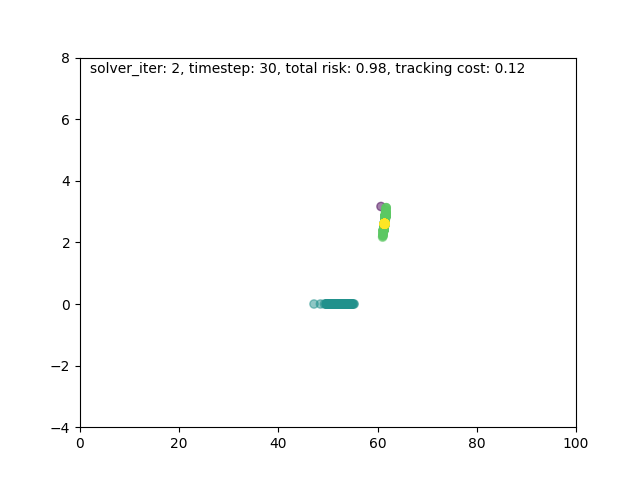

In [9]:
anim = animate_episode(predictor_data[episode_id]["solver_info"], predictor_data[episode_id]["ado_position_future"], predictor_data[episode_id]["ado_unbiased_predictions"])
anim.save(os.path.join(stats_dir, f"ep_{episode_id}_predictor.mp4"), writer="ffmpeg")